In [1]:
# Data Set Information:

# This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy 
# of probability of default among six data mining methods. From the perspective of risk management, the result of 
# predictive accuracy of the estimated probability of default will be more valuable than the binary result of
# classification - credible or not credible clients. Because the real probability of default is unknown, this
# study presented the novel Sorting Smoothing Method to estimate the real probability of default. With
# the real probability of default as the response variable (Y), and the predictive probability of default as
# the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting
# model produced by artificial neural network has the highest coefficient of determination; its regression
# intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining
# techniques, artificial neural network is the only one that can accurately estimate the real probability of default.

# Attribute Information:
# This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
# This study reviewed the literature and used the following 23 variables as explanatory 
# variables:
# LIMIT_BAL - X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and 
# his/her family (supplementary) credit.
# X2: Gender (1 = male; 2 = female).
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
# X4: Marital status (1 = married; 2 = single; 3 = others).
# X5: Age (year).

# X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) 
# as follows: 
# X6 = the repayment status in September, 2005; 
# X7 = the repayment status in August, 2005; 
# . . .;
# X11 = the repayment status in April, 2005. 
# The measurement scale for the repayment status is:
# -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; 
# . . .;
# 8 = payment delay for eight months; 9 = payment delay for nine months and above.

# X12-X17: Amount of bill statement (NT dollar). 
# X12 = amount of bill statement in September, 2005; 
# X13 = amount of bill statement in August, 2005; 
# . . .; 
# X17 = amount of bill statement in April, 2005.

# X18-X23: Amount of previous payment (NT dollar).
# X18 = amount paid in September, 2005; 
# X19 = amount paid in August, 2005;
# . . .;
# X23 = amount paid in April, 2005. 

In [2]:
# #run this to install the library we need
# !pip install --ignore-installed --upgrade tensorflow==1.9.0
# !pip install numpy
# !pip install pandas
# !pip install eli5
# !pip install shap
# !pip install matplotlib
# !pip install pdpbox
# !pip install sklearn

In [3]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import eli5
from eli5.sklearn import PermutationImportance
import shap
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print(f'Tensorflow version -- {tf.__version__}')

Tensorflow version -- 1.9.0


In [4]:
df = pd.read_excel('defaults.xls',header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
#load data

base_features = [feature for feature in df.columns if feature != "default_payment_next_month"]
# only use data which pass the sanity check
df = df.query('PAY_0 >= -1 and PAY_2 >= -1 and PAY_3 >= -1 and PAY_4 >= -1 and PAY_5 >= -1 and PAY_6 >= -1'
            +'and PAY_0 != 0 and PAY_2 != 0 and PAY_3 != 0 and PAY_4 != 0 and PAY_5 != 0 and PAY_6 != 0'
             +'and EDUCATION >= 1 and EDUCATION <= 4'
             +'and MARRIAGE >= 1')
df = df.sample(frac=1).reset_index(drop=True)
x=df[base_features]
y=df.default_payment_next_month
df.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
count,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,...,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000,4030.000000
mean,14274.161787,171657.568238,1.591811,1.742184,1.493300,36.522084,0.183871,0.289578,0.322581,0.287593,...,22618.342680,22590.346402,22701.868983,4654.058065,4609.700000,4719.065757,4547.375186,4605.919851,4590.067990,0.356328
std,8612.700739,125943.771452,0.491559,0.718360,0.516619,9.180649,1.575340,1.681448,1.738462,1.802048,...,44947.085387,44523.318928,45530.500711,10882.895838,11979.728987,13410.749346,11093.974616,13538.101017,14952.875407,0.478973
min,12.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-3903.000000,-3876.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6948.500000,60000.000000,1.000000,1.000000,1.000000,29.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,832.250000,846.000000,780.000000,316.000000,316.000000,316.000000,330.500000,98.000000,0.000000,0.000000
50%,13673.000000,150000.000000,2.000000,2.000000,1.000000,35.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,4180.000000,4087.000000,4162.000000,1600.000000,1595.000000,1443.000000,1443.500000,1228.000000,1048.000000,0.000000
75%,21664.000000,240000.000000,2.000000,2.000000,2.000000,43.000000,2.000000,2.000000,2.000000,2.000000,...,22900.500000,23345.500000,23999.250000,4411.750000,4395.250000,4200.000000,4100.000000,4000.000000,3710.000000,1.000000
max,29995.000000,740000.000000,2.000000,4.000000,3.000000,72.000000,8.000000,8.000000,8.000000,8.000000,...,486776.000000,503914.000000,527711.000000,187206.000000,302961.000000,417588.000000,193712.000000,303512.000000,345293.000000,1.000000


In [6]:
#Analyse data

#make a quick model in order to gain insight
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
quick_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(x_train, y_train)
perm = PermutationImportance(quick_model, random_state=1).fit(x_test, y_test)
#show the Feature Importance
eli5.show_weights(perm, top=40, feature_names = x_test.columns.tolist())

Weight,Feature
0.0331 ± 0.0138,PAY_0
0.0063 ± 0.0035,PAY_2
0.0032 ± 0.0067,BILL_AMT5
0.0008 ± 0.0066,PAY_6
0.0008 ± 0.0082,MARRIAGE
-0.0002 ± 0.0109,PAY_5
-0.0012 ± 0.0085,BILL_AMT1
-0.0012 ± 0.0058,BILL_AMT2
-0.0018 ± 0.0068,PAY_4
-0.0022 ± 0.0071,PAY_AMT5


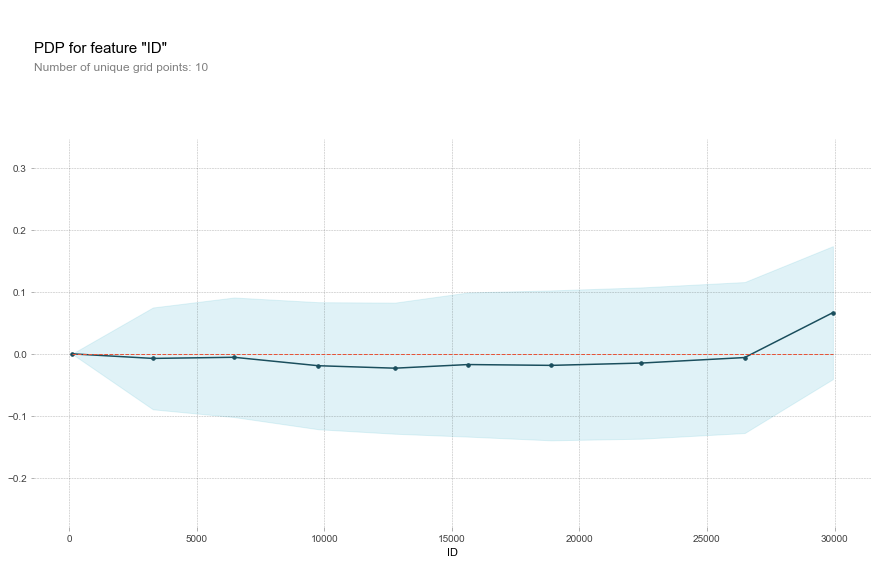

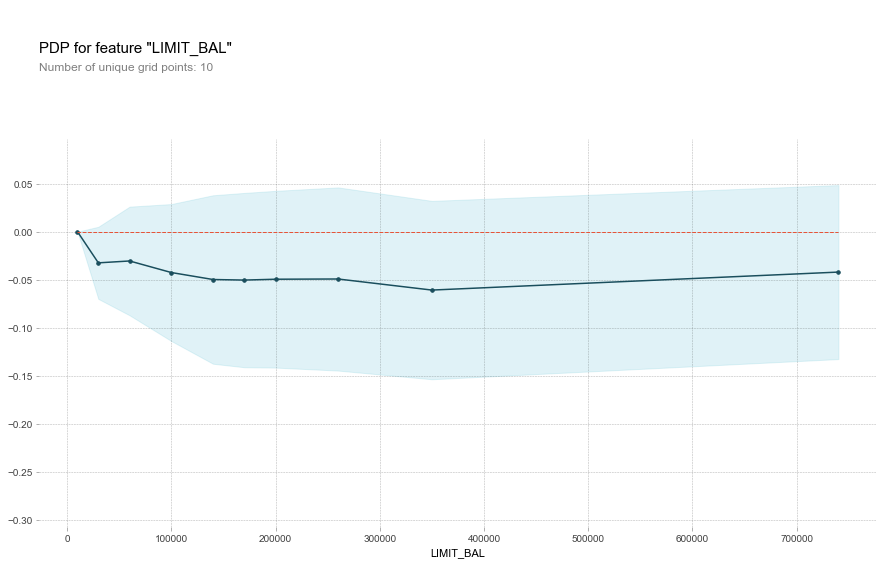

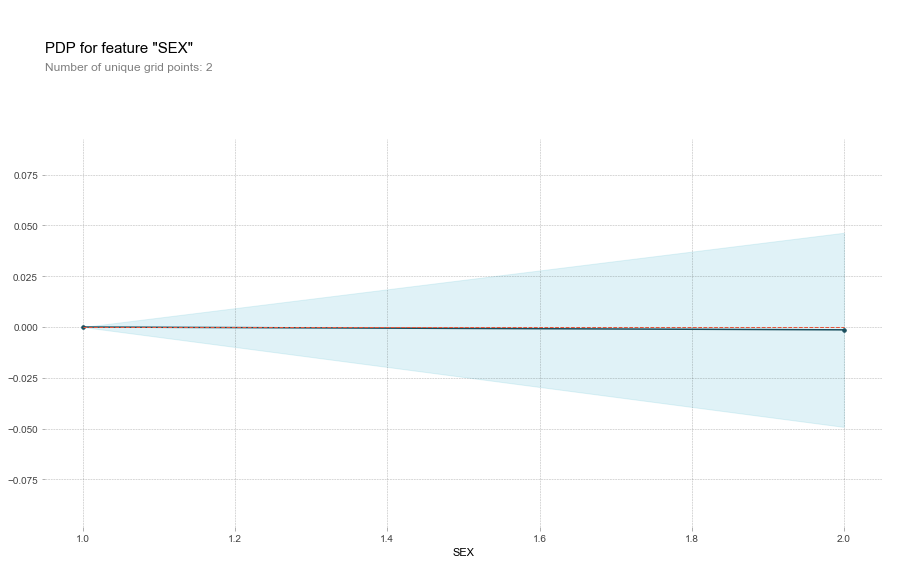

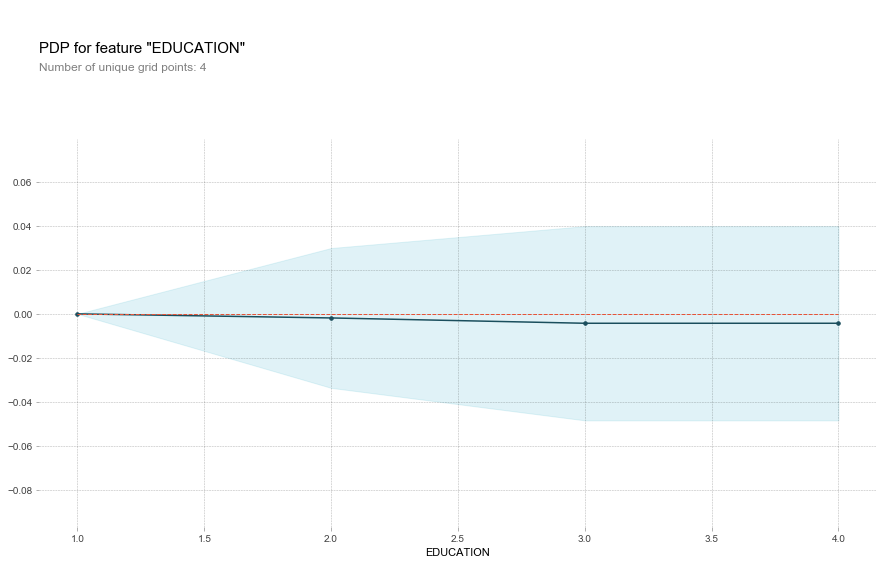

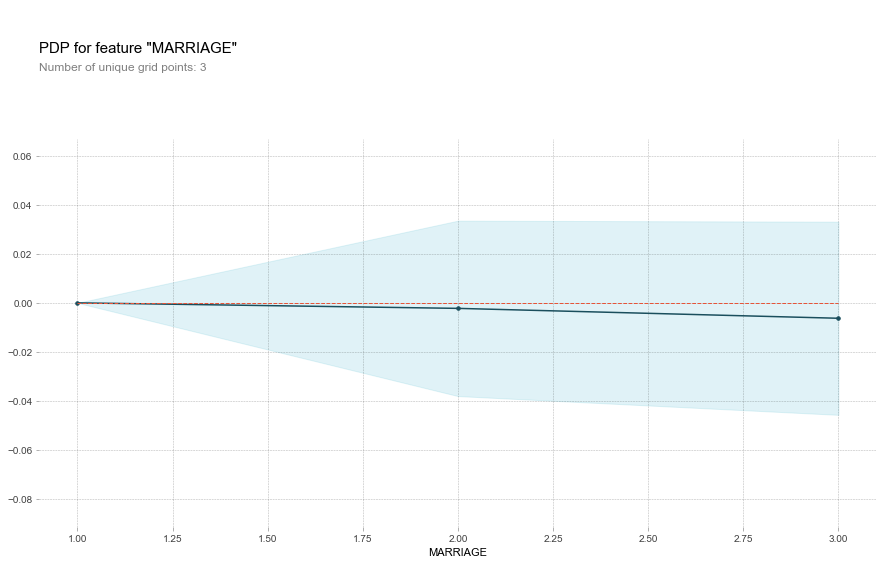

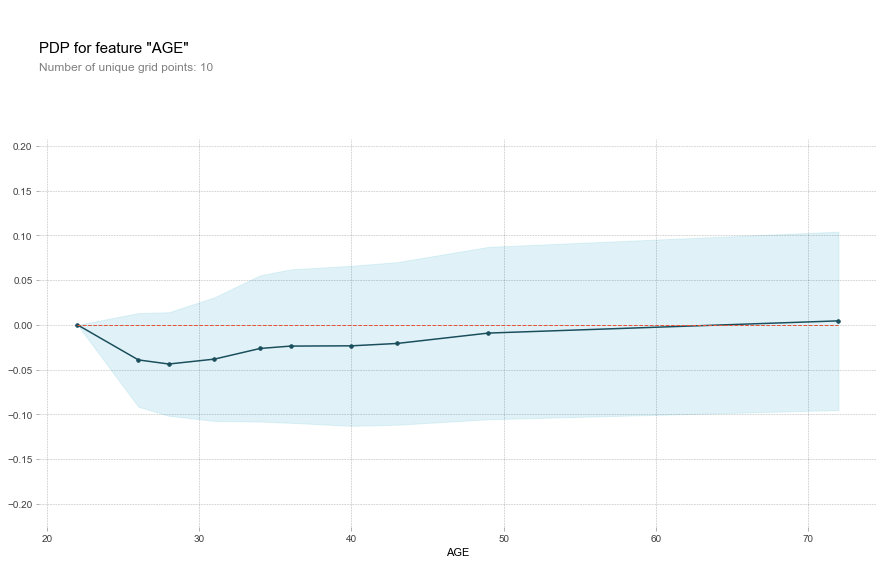

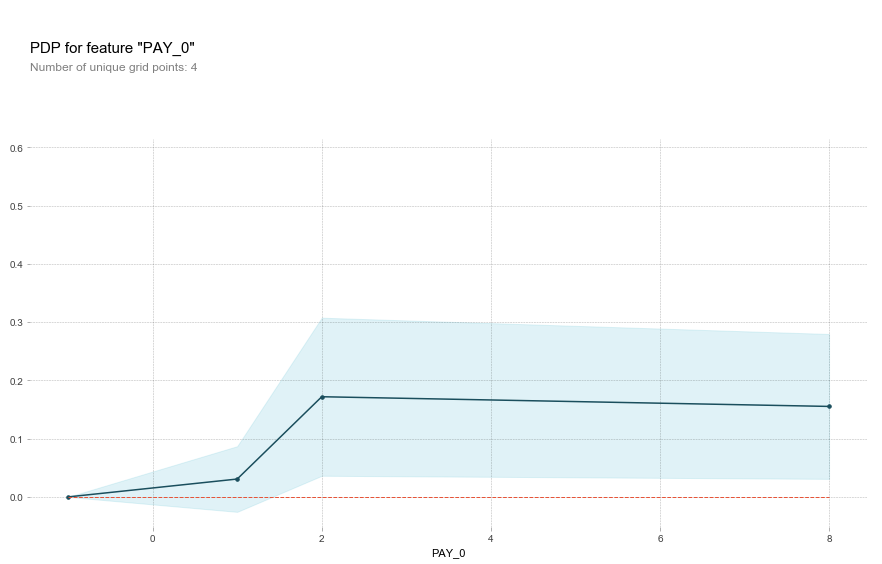

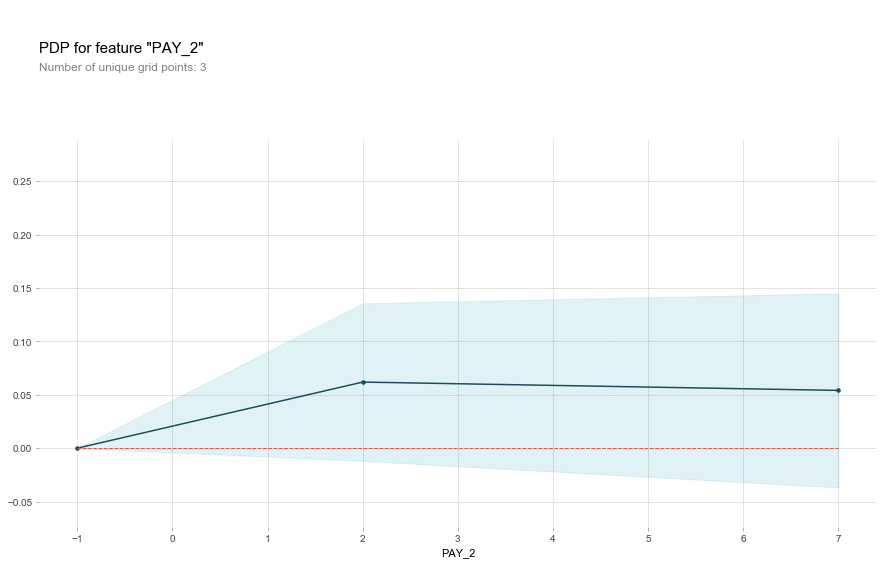

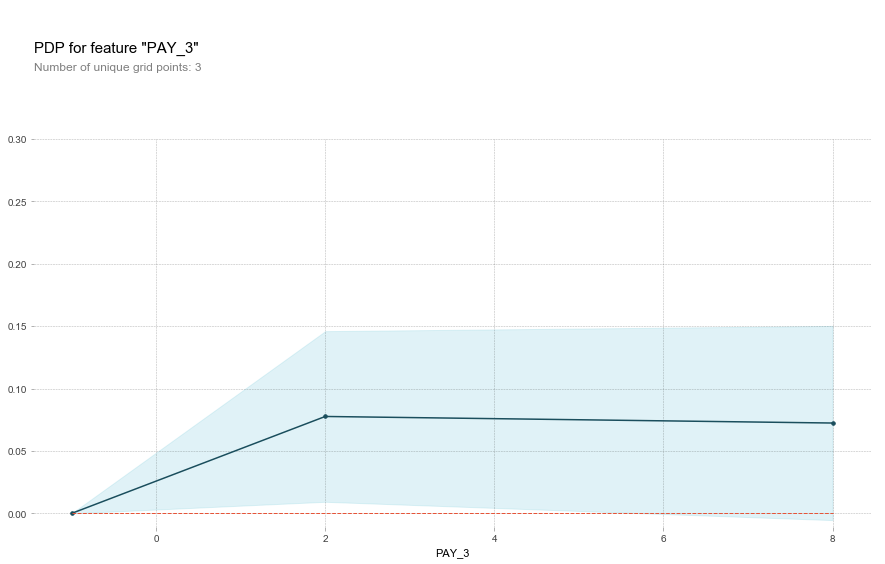

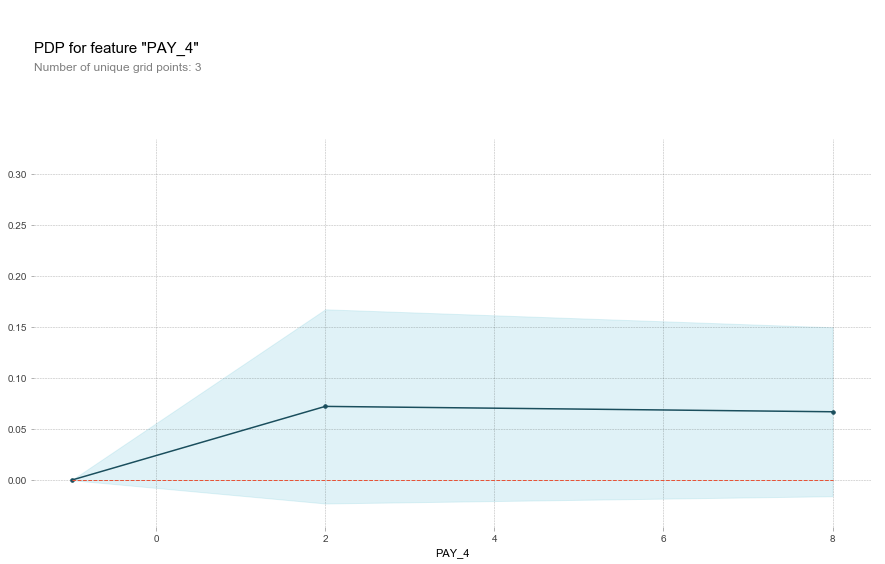

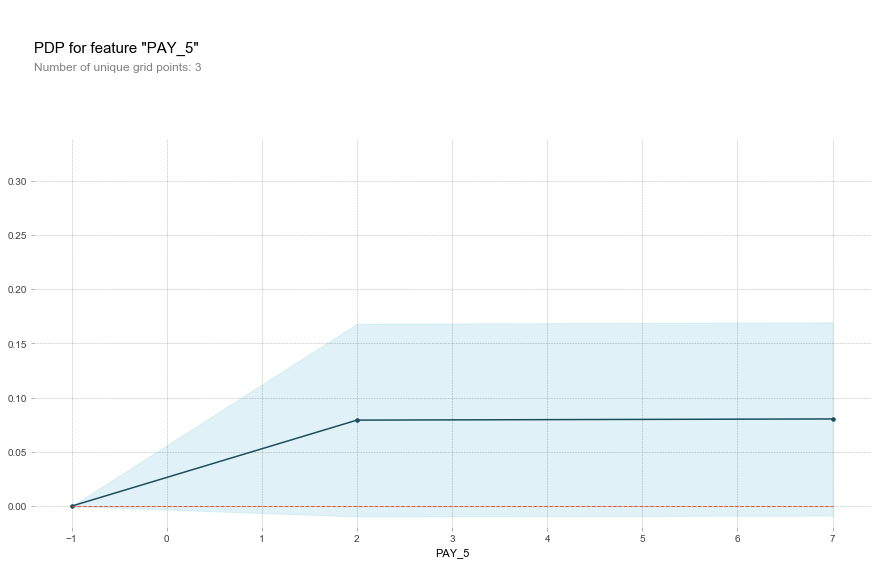

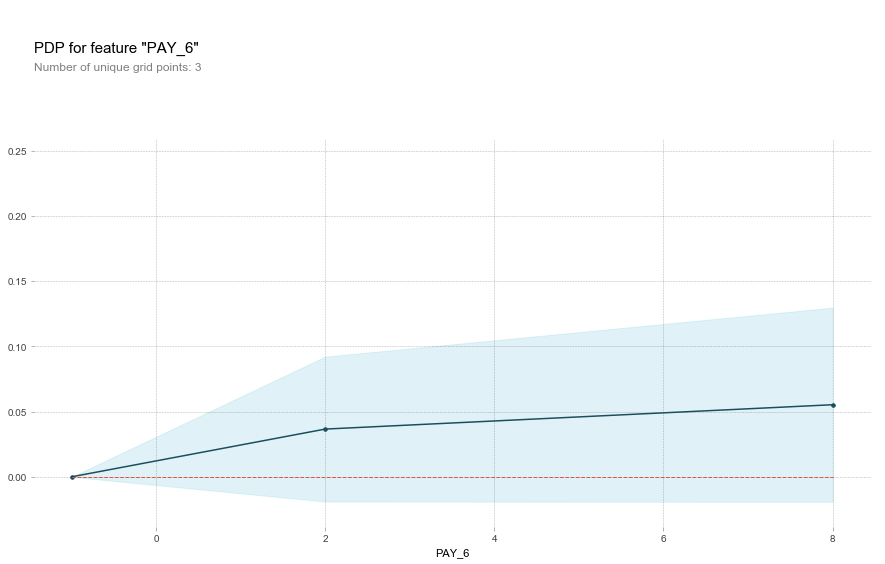

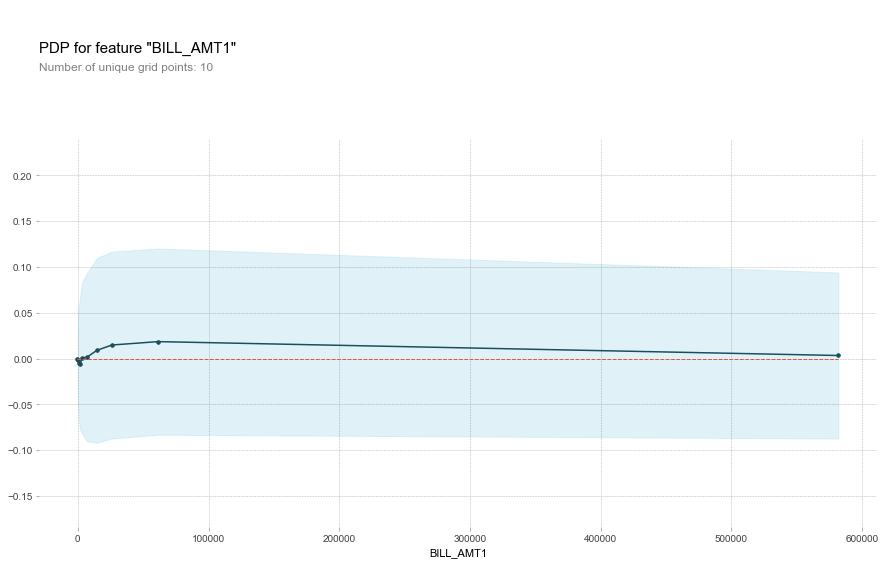

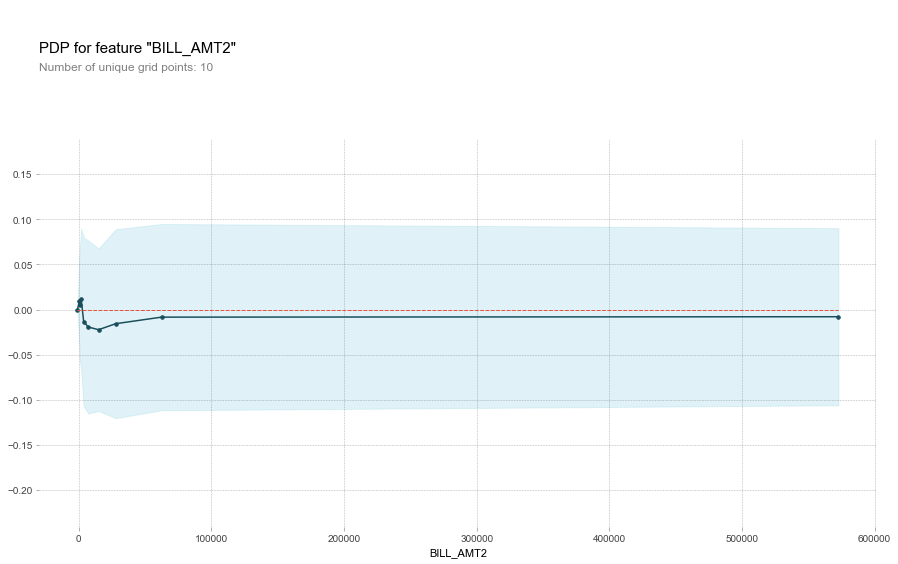

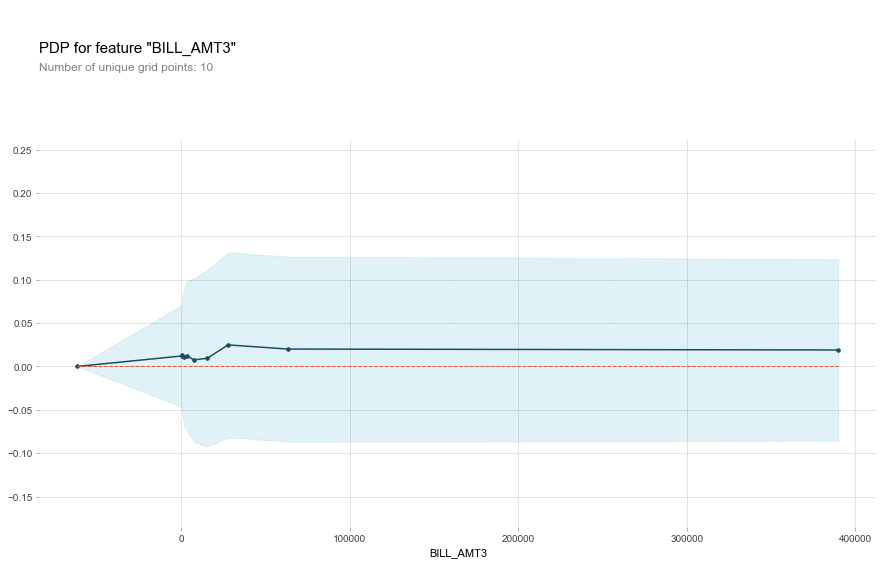

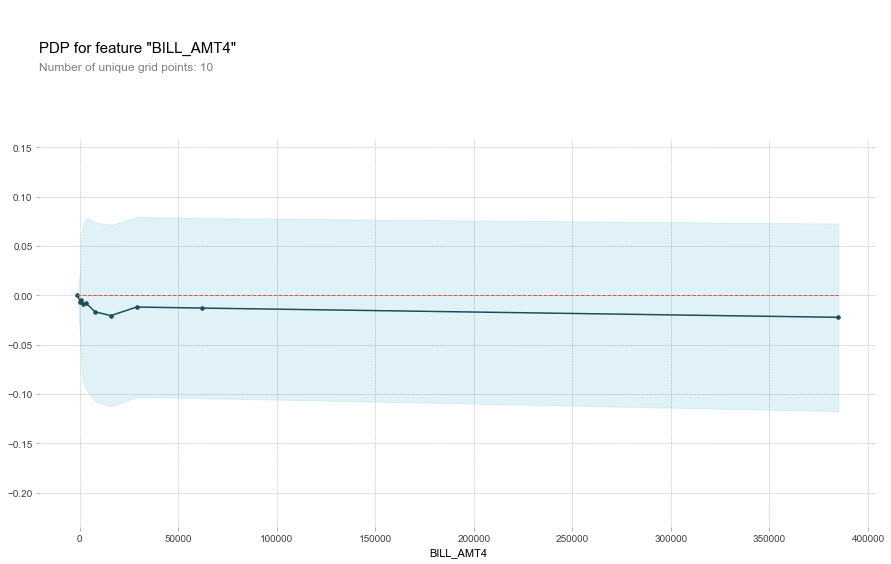

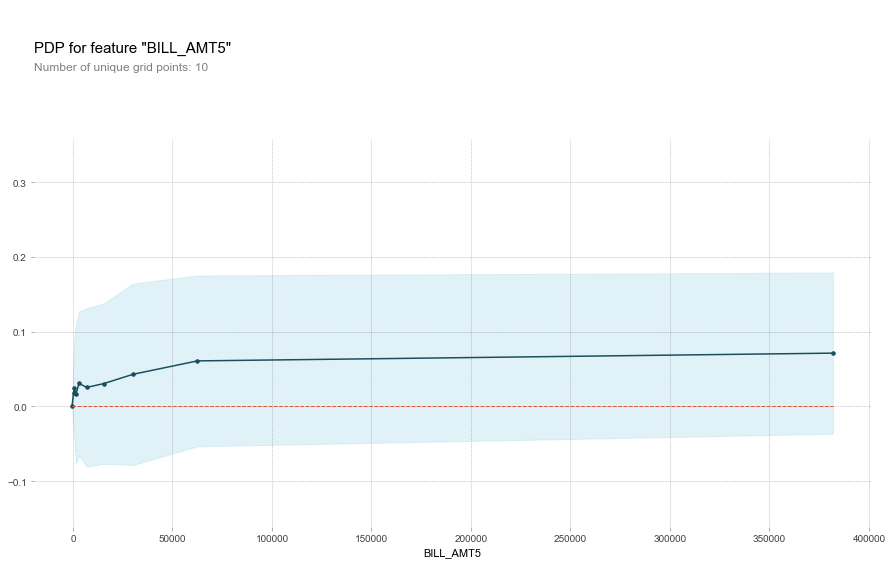

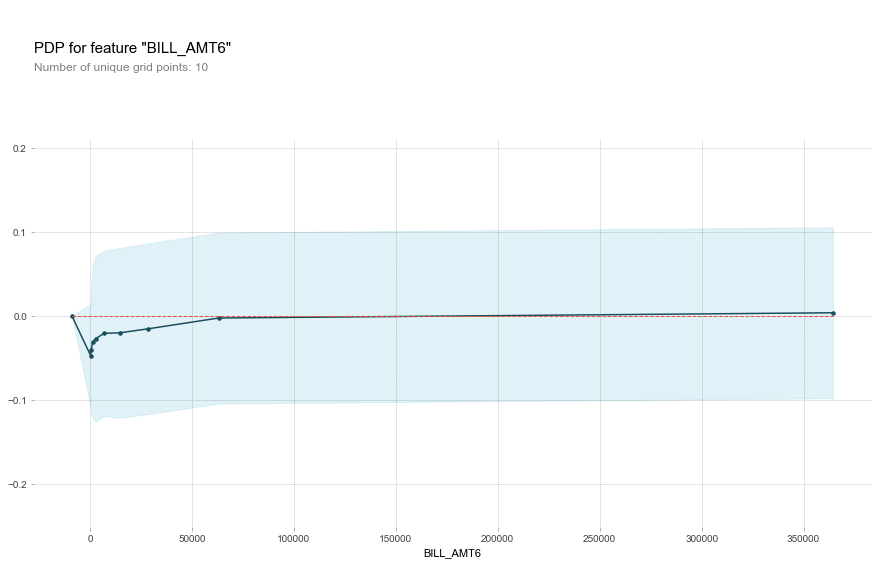

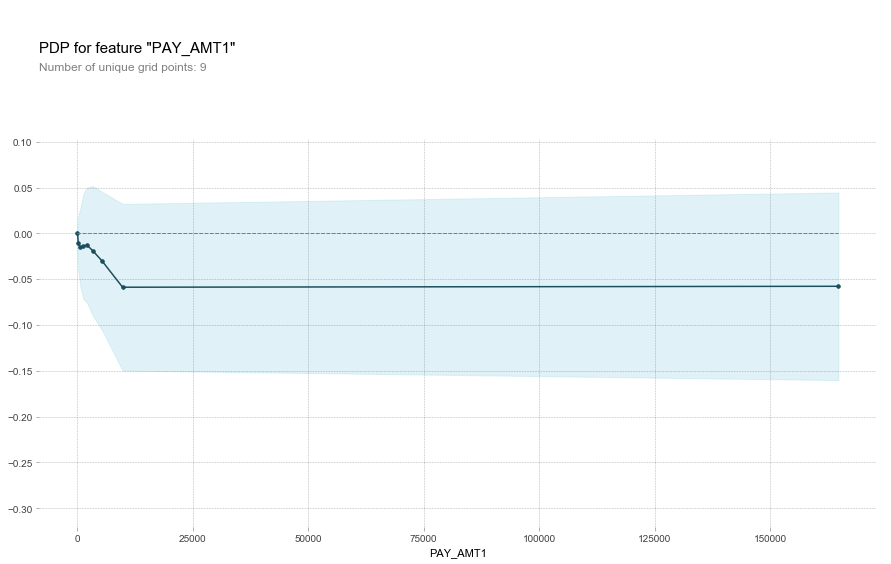

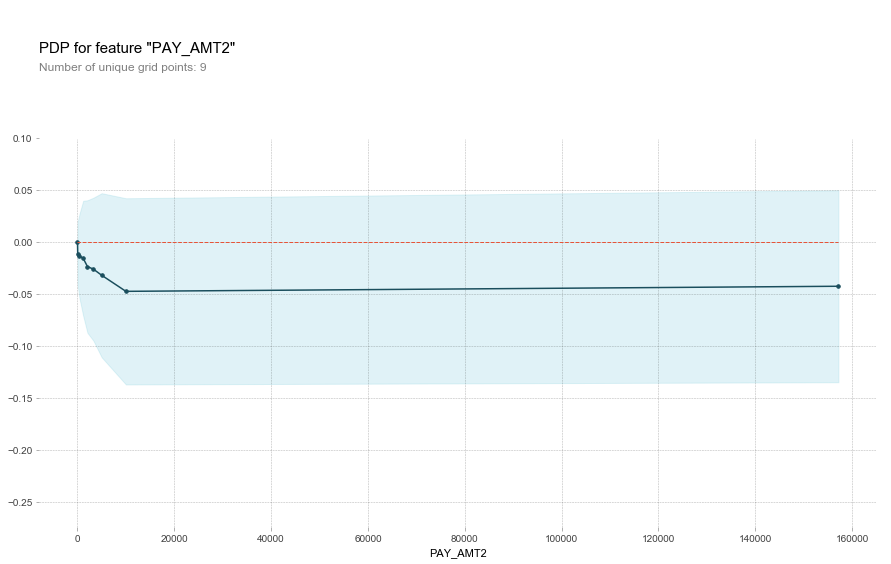

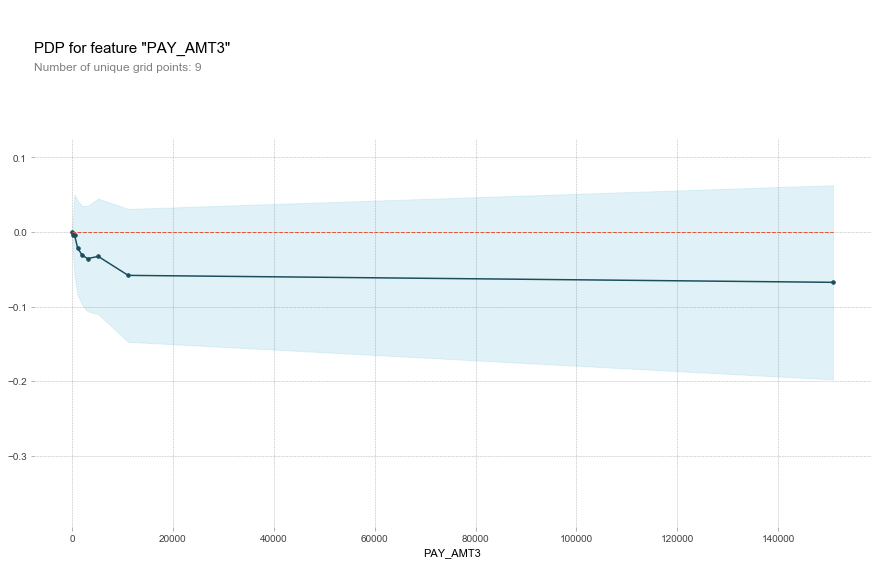

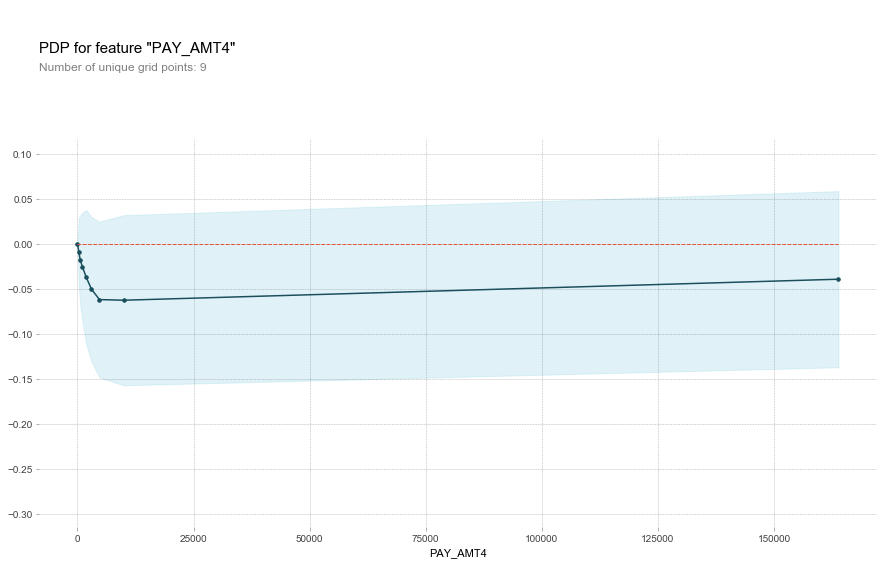

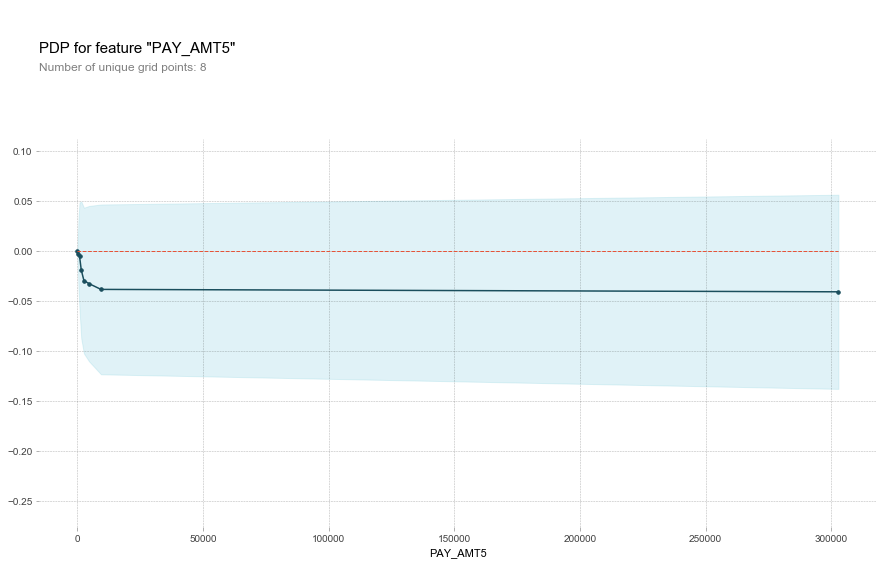

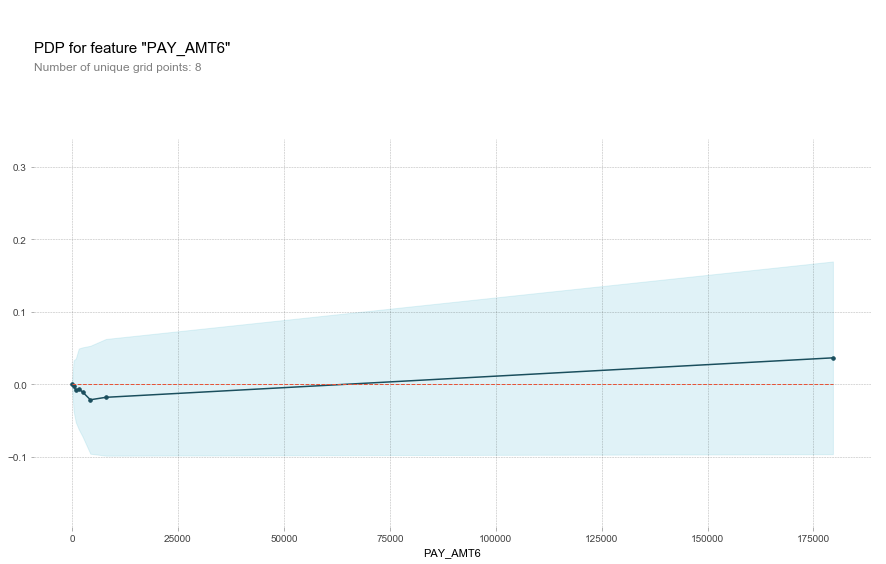

In [7]:
#show the Partial Dependency Plot of every feature
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=quick_model, dataset=x_test, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
    plt.show()

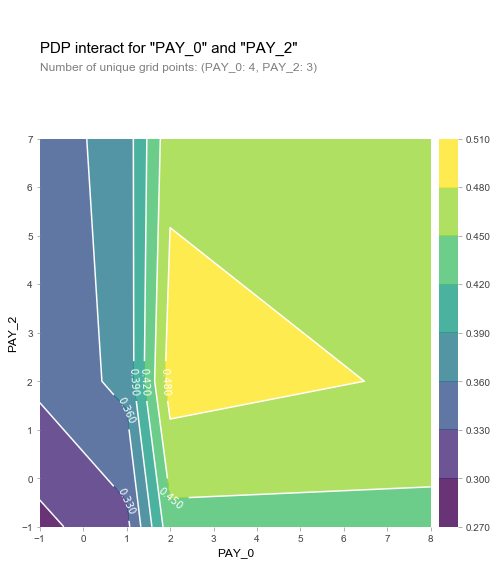

In [8]:
#show the Partial Dependency Interact Plot of features 'PAY_0', 'PAY_3'
fname=['PAY_0', 'PAY_2']
inter1  =  pdp.pdp_interact(model=quick_model, dataset=x_test, model_features=base_features, features=fname)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=fname, plot_type='contour')
plt.show()

In [9]:
#Feature Engineering

#try feature engineering, to see if average bill amount makes a good feature
#the result is that no, it is only an alright feature
avg_bill_amt = [df.BILL_AMT1,df.BILL_AMT2,df.BILL_AMT3,df.BILL_AMT4,df.BILL_AMT5,df.BILL_AMT6]
df['avg_bill_amt'] =sum(avg_bill_amt)/len(avg_bill_amt)
new_features=base_features.copy()
new_features.append('avg_bill_amt')
x = df[new_features]
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x, y, random_state=1)
second_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(new_x_train, new_y_train)
perm = PermutationImportance(second_model).fit(new_x_test, new_y_test)
#show the Feature Importance of the second_model
eli5.show_weights(perm, top=40, feature_names = new_x_test.columns.tolist())

Weight,Feature
0.0401 ± 0.0158,PAY_0
0.0196 ± 0.0080,PAY_2
0.0123 ± 0.0062,PAY_4
0.0087 ± 0.0090,PAY_5
0.0071 ± 0.0108,avg_bill_amt
0.0069 ± 0.0028,PAY_AMT2
0.0058 ± 0.0055,PAY_6
0.0048 ± 0.0147,BILL_AMT5
0.0044 ± 0.0048,SEX
0.0044 ± 0.0054,BILL_AMT1


In [ ]:
explainer = shap.TreeExplainer(second_model)
shap_values2 = explainer.shap_values(new_x_test)
#show the Dependence Plot of the new feature
shap.dependence_plot('avg_bill_amt', shap_values2[1], new_x_test)

In [ ]:
#try feature engineering again, to see if average pay makes a good feature
#the result is that no, it is not a good feature
avg_pay = [df.PAY_0,df.PAY_2,df.PAY_3,df.PAY_4,df.PAY_5,df.PAY_6]
df['avg_pay'] =sum(avg_pay)/len(avg_pay)
avg_pay_features=base_features.copy()
avg_pay_features.append('avg_pay')
x = df[avg_pay_features]
new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(x, y, random_state=1)
third_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(new_x_train, new_y_train)
perm = PermutationImportance(second_model).fit(new_x_test, new_y_test)
eli5.show_weights(perm, top=40, feature_names = new_x_test.columns.tolist())

In [ ]:
explainer = shap.TreeExplainer(third_model)
shap_values2 = explainer.shap_values(new_x_test)
shap.dependence_plot('avg_pay', shap_values2[1], new_x_test)

In [ ]:
# Come back to the first quick model
# check the reason the model predict the first person in test sample will not default repayment the next month
sample_data_for_prediction = x_test.iloc[0].astype(float)  # to test function
explainer = shap.TreeExplainer(quick_model)
shap_values = explainer.shap_values(sample_data_for_prediction)
shap.initjs()
#show force_plot to explain the prediction
shap.force_plot(explainer.expected_value[1], shap_values[1], sample_data_for_prediction)

In [ ]:
explainer = shap.TreeExplainer(quick_model)
shap_values = explainer.shap_values(x_test)
#show summary_plot of each features
shap.summary_plot(shap_values[1], x_test)

In [ ]:
# show dependence_plot to explain the relationship between predictions and features
for feat_name in base_features:
    shap.dependence_plot(feat_name, shap_values[1], x_test)

In [ ]:
#Build Models
#Prepare data

df = pd.read_excel('defaults.xls',header=1)
#ID of customer should not be a feature in the model
base_features = [feature for feature in df.columns if feature != "default_payment_next_month" and feature != "ID"]
df = df.query('PAY_0 >= -1 and PAY_2 >= -1 and PAY_3 >= -1 and PAY_4 >= -1 and PAY_5 >= -1 and PAY_6 >= -1'
              'and PAY_0 != 0 and PAY_2 != 0 and PAY_3 != 0 and PAY_4 != 0 and PAY_5 != 0 and PAY_6 != 0'
             +'and EDUCATION >= 1 and EDUCATION <= 4'
             +'and MARRIAGE >= 1')
df = df.sample(frac=1).reset_index(drop=True)
d_norm = (df - df.mean()) / (df.max() - df.min())
x=d_norm[base_features]
y=df.default_payment_next_month
x_numpy = x.values
y_numpy = y.values
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, random_state=1)

#when using Jupyter Notebook
dir = os.getcwd()

# # when using local runtime
# dir = os.path.dirname(__file__)

#make the file directories that will be needed
new_dir = os.path.join(dir, 'logs') 
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
new_dir = os.path.join(dir, 'models') 
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
new_dir = os.path.join(dir, 'tensorflow_models') 
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

In [ ]:
# Using Keras


k_model = keras.Sequential(layers=[
            layers.Flatten(input_shape=(23,)),
            layers.Dense(32, activation='relu'),
#             layers.Dropout(0.2),
            layers.Dense(2, activation='softmax')
        ])

k_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


filepath = os.path.join(dir, 'models/defaults_keras_model.hdf5')
log_dir = os.path.join(dir, 'logs/1')
callbacks = [
    callbacks.ModelCheckpoint(filepath=filepath, verbose=1,
                             monitor='val_loss', save_best_only=True),
    #Check out the train history later with Tensorboard
    callbacks.TensorBoard(log_dir=log_dir),
    callbacks.EarlyStopping(patience=1)
]

k_model.fit(x_train, y_train, epochs=1000, validation_split=0.1, verbose=2,
                  callbacks=callbacks)
del k_model
k_model = models.load_model(filepath=filepath)
test_result = k_model.evaluate(x=x_test, y=y_test)
print(f'Test result:\nTest loss = {test_result[0]}, Test accuracy = {test_result[1]}')

In [ ]:
#make prediction with Keras

k_predictions = k_model.predict(x_test)
j=[]
k=[]
for i in range(10):
    j.append(np.argmax(k_predictions[i]))
    k.append(y_test[i])
print(f'Showing predictions and true labels of the first {len(j)} test samples --')
print(f'The predictions are {j}')
print(f'The true labels are {k}')

In [ ]:
#Using Tensorflow


dir = os.getcwd()
with tf.Session() as sess:
    # Specify that all features have real-value data
    feature_name = "defaults_features"
    feature_columns = [tf.feature_column.numeric_column(feature_name, shape=(1, 23))]
    
    #use the DNNClassifier
    tf_classifier = tf.estimator.DNNClassifier(
        hidden_units=[32],
        feature_columns=feature_columns,
        n_classes=2,
#         dropout=0.2,
        model_dir=os.path.join(dir, 'tensorflow_models'))
    
#     #can also try the Linear Classifier
#     tf_classifier = tf.estimator.LinearClassifier(
#         feature_columns=feature_columns,
#         n_classes=2,
#         model_dir=os.path.join(dir, 'tensorflow_models'))

    def input_fn(x, y):
        def _fn():
            features = {feature_name: tf.constant(x)}
            label = tf.constant(y)
            return features, label
        return _fn

    # Fit model.
    with tf.name_scope("train"):
        tf_classifier.train(input_fn=input_fn(x_train, y_train), steps=200)
    print('fit done')

    with tf.name_scope("evaluate"):
        # Evaluate accuracy.
        accuracy_score = tf_classifier.evaluate(
            input_fn=input_fn(x_test, y_test), steps=1)["accuracy"]
    print('\nAccuracy: {0:f}'.format(accuracy_score))

    # Export the model for serving
    feature_spec = {'defaults_features': tf.FixedLenFeature(
        shape=(1, 23), dtype=np.float32)}

    serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec)

tf_classifier.export_savedmodel(export_dir_base=os.path.join(dir, 'tensorflow_models'),
                             serving_input_receiver_fn=serving_fn)

In [ ]:
# #make prediction with Tensorflow
# #making prediction will lead to finalizing the graph, therefore we skip this part for now
# tf_predictions = tf_classifier.predict(
#     input_fn=input_fn(x_test, y_test),
#     predict_keys=None,
#     hooks=None,
#     checkpoint_path=None,
#     yield_single_examples=True
# )
# j=[]
# k=[]
# for i in range(10):
#     j.append(int(next(tf_predictions)['class_ids']))
#     k.append(y_test[i])
# print(f'Showing predictions and true labels of the first {len(j)} test samples --')
# print(f'The predictions are {j}')
# print(f'The true labels are {k}')

In [ ]:
#convert the Keras model to Tensorflow estimator for Scaling up, which is with the Distributed train built in 
# + easier to do model serving

k_tf_classifier = tf.keras.estimator.model_to_estimator(
    keras_model=k_model,
    keras_model_path=None,
    custom_objects=None,
    model_dir=None,
    config=None
)

input_name = k_model.input_names[0]

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={input_name: x_train},
    y=y_train,
    num_epochs=1,
    shuffle=False
)
with tf.name_scope("train"):
    k_tf_classifier.train(input_fn=train_input_fn)
    print('fit done')


eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={input_name: x_test},
    y=y_test,
    batch_size=1,
    shuffle=False
)
with tf.name_scope("evaluate"):
    accuracy_score = k_tf_classifier.evaluate(
        input_fn=eval_input_fn)["accuracy"]
    print('\nAccuracy: {0:f}'.format(accuracy_score))
    
    # Export the model for serving
feature_spec = {input_name: tf.FixedLenFeature(
        shape=(1, 23), dtype=np.float32)}

serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec)

k_tf_classifier.export_savedmodel(export_dir_base=os.path.join(dir, 'tensorflow_models'),
                             serving_input_receiver_fn=serving_fn)

In [ ]:
#make prediction with Tensorflow
k_tf_predictions = k_tf_classifier.predict(
    input_fn=eval_input_fn,
    predict_keys=None,
    hooks=None,
    checkpoint_path=None,
    yield_single_examples=True
)
j=[]
k=[]
for i in range(10):
    j.append(np.argmax((next(k_tf_predictions))['dense_1']))
    k.append(y_test[i])
print(f'Showing predictions and true labels of the first {len(j)} test samples --')
print(f'The predictions are {j}')
print(f'The true labels are {k}')